# 0. Introduction
This is a notebook that contains and makes some ensemble plots for a PMIP collaborative effort to get a multi-model paper describing some broad features of the mid-Holocene simulations. 

## General steps before making plots
This part includes:
1. Download input files
2. Import packages
3. Define some functions for loading data. Don't make any changes to this part.



### Download data
This step will download the input data files package called PMIP4_midHolocence_cvdp_data.tar.gz, and then unpack the folders and files into data dictory.




In [ ]:
#press Enter + Shift to run coding cells
#No change needs here

! ../scripts/download_cvdp_data.sh

#### You will get the following files/folders in your data dictory:
1. abrupt4xCO2 
2. historical 
3. midHolocene
4. midHolocene-cal-adj
5. piControl
6. C20-Reanalysis.cvdp_data.1871-2012.nc  #observations
7. GPCP.cvdp_data.1979-1999.nc

### Import packages and define fucntions for calculations

In [1]:
'''Import packages for loading data, analysing, and plotting'''

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xesmf as xe
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import matplotlib
from netCDF4 import Dataset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import math
import os
import matplotlib.colors as colors


In [2]:
 #No change needs here

'''Define CMIP list'''
# This cell lists CMIP/PMIP model groups

pmip4=['IPSL-CM6A-LR',
       'HadGEM3-GC31',
       'AWI-ESM']

pmip3=['GISS-E2-1-G',
     'COSMOS-ASO',
     'MRI-CGCM3',
     'CNRM-CM5',
     'FGOALS-g2',
     'GISS-E2-R',
     'EC-EARTH-2-2',
     'IPSL-CM5A-LR',
     'bcc-csm1-1',
     'HadGEM2-CC',
     'HadCM3',
     'MPI-ESM-P',
     'CCSM4',
     'CSIRO-Mk3L-1-2',
     'CSIRO-Mk3-6-0',
     'FGOALS-s2',
     'MIROC-ESM']
pmip_all=['GISS-E2-1-G',
 'COSMOS-ASO',
 'AWI-ESM',
 'MRI-CGCM3',
 'CNRM-CM5',
 'FGOALS-g2',
 'GISS-E2-R',
 'EC-EARTH-2-2',
 'IPSL-CM5A-LR',
 'IPSL-CM6A-LR',
 'bcc-csm1-1',
 'HadGEM3-GC31',
 'HadGEM2-CC',
 'HadCM3',
 'MPI-ESM-P',
 'CCSM4',
 'CSIRO-Mk3L-1-2',
 'CSIRO-Mk3-6-0',
 'FGOALS-s2',
 'MIROC-ESM']

pmip={}
pmip['PMIP3']=pmip3
pmip['PMIP4']=pmip4
pmip['PMIP']=pmip_all

pmip_v3='PMIP3'
pmip_v4='PMIP4'

In [4]:
#No change needs here

'''Define calculating functions'''

#This function will get all available experiment names
def experimentlist():
    exps=[]
    file_path = "data" 
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for d in dirnames:
            exps.append(d)
    return exps

#This function will get all available model names in the experiment 
def modellist(experiment_name):
    models=[]
    file_path = "data/%s" %(experiment_name)
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for f in filenames:
            mname=f.split("_")[0]
            models.append(mname)
    return models

#This function will get all available filenames in the experiment 
def filenamelist(experiment_name):
    filenames=[]
    file_path = "data/%s" %(experiment_name)
    for dirpaths, dirnames, files in os.walk(file_path):
        for f in files:
            ff='data/%s/%s'%(experiment_name,f)
            filenames.append(ff)
    return filenames

#This function will identify models in the ensemble
def identify_ensemble_members(variable_name,experiment_name):
    datadir="data/%s" %(experiment_name)
    ensemble_members=!scripts/find_experiment_ensemble_members.bash {experiment_name} {variable_name} {datadir}
    return ensemble_members

#This function will list excat model name
def extract_model_name(filename):
    file_no_path=filename.rpartition("/")
    file_strings=file_no_path[2].partition("_")
    model_name=file_strings[0]
    return model_name

def ensemble_members_dict(variable_name,experiment_name):
    ens_mems=identify_ensemble_members(variable_name,experiment_name)
    ens_mems_dict={extract_model_name(ens_mems[0]):ens_mems[0]}
    for mem in ens_mems[1:]:
        ens_mems_dict[extract_model_name(mem)]=mem
    return ens_mems_dict
    
#This function will calculate the ensemble average
def ensemble_mean(pmip_v):
    n=0
    average=0
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(-0, 360, 1.0))})
    gcm_dict=ensemble_members_dict(variable_name,experiment_name)
    for gcm in gcm_dict:
        if gcm in pmip[pmip_v]:
            this_file=xr.open_dataset(gcm_dict.get(gcm),decode_times=False)
            this_var=this_file[variable_name]
            this_regridder=xe.Regridder(this_file,grid_1x1,'bilinear', reuse_weights=True,periodic=True) 
            var_1x1=this_regridder(this_var)
            average=(n*average+var_1x1)/(n+1)
            n=n+1
    ensemble_ave_r=np.zeros((180,360))
    for r in range(180):
        for c in range(360):
            ensemble_ave_r[r][c]=average[r][c-180]            
    return ensemble_ave_r

#This function will calculate the difference between experiment and piControl for each model, 
#and then calculate the ensemble average of the differences
def ensemble_mean_diffence(pmip_v):
    n=0
    average=0
    A_dict=ensemble_members_dict(variable_name,experiment_name)
    B_dict=ensemble_members_dict(variable_name,'piControl')
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(-0, 360., 1.0))})
    for gcm in A_dict:
        if gcm in B_dict:
            if gcm in pmip[pmip_v]:
                expt_a_file=xr.open_dataset(A_dict.get(gcm),decode_times=False)
                expt_a=expt_a_file[variable_name]
                expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
                expt_b=expt_b_file[variable_name]
                diff=expt_a-expt_b
                this_regridder=xe.Regridder(expt_a_file,grid_1x1,'bilinear', reuse_weights=True,periodic=True) 
                diff_1x1=this_regridder(diff)
                average=(n*average+diff_1x1)/(n+1)
                n=n+1
    ensemble_diff_r=np.zeros((180,360))
    for r in range(180):
        for c in range(360):
            ensemble_diff_r[r][c]=average[r][c-180]
    return ensemble_diff_r

#This function will calculate the difference between experiment and piControl for each model, 
#and then calculate the ensemble stddev of the differences
def ensemble_stddev(pmip_v):
    dataset=[]
    A_dict=ensemble_members_dict(variable_name,experiment_name)
    B_dict=ensemble_members_dict(variable_name,'piControl')
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(-0, 360., 1.0))})
    for gcm in A_dict:
        if gcm in B_dict:
            if gcm in pmip[pmip_v]:
                expt_a_file=xr.open_dataset(A_dict.get(gcm),decode_times=False)
                expt_a=expt_a_file[variable_name]
                expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
                expt_b=expt_b_file[variable_name]
                diff=expt_a-expt_b
                this_regridder=xe.Regridder(expt_a_file,grid_1x1,'bilinear', reuse_weights=True,periodic=True) 
                diff_1x1=this_regridder(diff)
                dataset.append(diff_1x1)
    data=np.array(dataset)
    std=np.std(data,axis=0)
    stddev_diff_r=np.zeros((180,360))
    for r in range(180):
        for c in range(360):
            stddev_diff_r[r][c]=std[r][c-180]
    return stddev_diff_r

In [2]:
#No change needs here

'''Define plotting functions'''
#This fuction will plot Robinson projected Geo2D map for averaged temperature in deg_C
def tas_ave_plot(experiment_name,variable_name):
    cmap=plt.get_cmap('RdYlBu_r')
    projection = ccrs.Robinson()
    transform=ccrs.PlateCarree()
    clim=[-1.5,1.5]
    bounds = np.linspace(-1.5, 1.5, 11)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(21, 18), subplot_kw={'projection': ccrs.Robinson()})
    ax1=axs[0]
    ax2=axs[1]
    ax3=axs[2]
    ax1.set_title('PMIP4/CMIP6')
    ax1.coastlines()
    ax1.gridlines()
    fig1=ax1.imshow(ensemble_diff_v4, transform=transform,cmap=cmap,clim=clim,norm=norm)
    ax2.set_title('PMIP3/CMIP5')
    ax2.coastlines()
    ax2.gridlines()
    fig2=ax2.imshow(ensemble_diff_v3, transform=transform,cmap=cmap,clim=clim,norm=norm)
    ax3.set_title('PMIP4-PMIP3')
    ax3.coastlines()
    ax3.gridlines()
    fig3=ax3.imshow(ensemble_diff_v, transform=transform,cmap=cmap,clim=clim,norm=norm)
    cax,kw = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.5)
    plt.colorbar(fig3, cax=cax, **kw,extend='both')
    return fig

#Same as above but for uncertainty, i.e. stddev
def tas_std_plot(experiment_name,variable_name):
    cmap=plt.get_cmap('YlOrRd')
    clim=[0,1.5]
    bounds = np.linspace(0, 1.5, 11)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(21, 18), subplot_kw={'projection': ccrs.Robinson()})
    ax1=axs[0]
    ax2=axs[1]
    title= 'PMIP4' 
    ax1.set_title(title)
    ax1.coastlines()
    ax1.gridlines()
    fig1=ax1.imshow(ensemble_stddev_v4, transform=ccrs.PlateCarree(),cmap=cmap,clim=clim,norm=norm)
    title= 'PMIP3' 
    ax2.set_title(title)
    ax2.coastlines()
    ax2.gridlines()
    fig2=ax2.imshow(ensemble_stddev_v3, transform=ccrs.PlateCarree(),cmap=cmap,clim=clim,norm=norm)
    cax,kw = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.5)
    plt.colorbar(fig2, cax=cax, **kw,extend='max')
    return fig
#This fuction will plot Robinson projected Geo2D map for averaged precipitation rate in mm/day
def pr_ave_plot(experiment_name,variable_name):
    cmap=plt.get_cmap('BrBG')
    projection = ccrs.Robinson()
    transform=ccrs.PlateCarree()
    clim=[-1,1]
    bounds = np.linspace(-1, 1, 11)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(21, 18), subplot_kw={'projection': ccrs.Robinson()})
    ax1=axs[0]
    ax2=axs[1]
    ax3=axs[2]
    ax1.set_title('PMIP4/CMIP6 ')
    ax1.coastlines()
    ax1.gridlines()
    fig1=ax1.imshow(ensemble_diff_v4, transform=transform,cmap=cmap,clim=clim,norm=norm)
    ax2.set_title('PMIP3/CMIP5')
    ax2.coastlines()
    ax2.gridlines()
    fig2=ax2.imshow(ensemble_diff_v3, transform=transform,cmap=cmap,clim=clim,norm=norm)
    ax3.set_title('PMIP4-PMIP3')
    ax3.coastlines()
    ax3.gridlines()
    fig3=ax3.imshow(ensemble_diff_v, transform=transform,cmap=cmap,clim=clim,norm=norm)
    cax,kw = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.5)
    plt.colorbar(fig3, cax=cax, **kw,extend='both')
    return fig
#Same as above but for uncertainty, i.e. stddev
def pr_std_plot(experiment_name,variable_name):
    cmap=plt.get_cmap('YlGn')
    clim=[0,1.5]
    bounds = np.linspace(0, 1.5, 11)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(21, 18), subplot_kw={'projection': ccrs.Robinson()})
    ax1=axs[0]
    ax2=axs[1]
    title= 'PMIP4' 
    ax1.set_title(title)
    ax1.coastlines()
    ax1.gridlines()
    fig1=ax1.imshow(ensemble_stddev_v4, transform=ccrs.PlateCarree(),cmap=cmap,clim=clim,norm=norm)
    title= 'PMIP3' 
    ax2.set_title(title)
    ax2.coastlines()
    ax2.gridlines()
    fig2=ax2.imshow(ensemble_stddev_v3, transform=ccrs.PlateCarree(),cmap=cmap,clim=clim,norm=norm)
    cax,kw = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.5)
    plt.colorbar(fig2, cax=cax, **kw,extend='max')
    return fig

# 1. Experiment and variable names

In [4]:
'''experiment'''
# midHolocene-cal-adj
# midHolocene
# piControl
# historical
# abrupt4xCO2


'''variable names in each data file'''
#pr_spatialmean_ann
#pr_spatialmean_djf
#pr_spatialmean_jja
#pr_spatialmean_mam
#pr_spatialmean_son
#pr_spatialstddev_ann
#pr_spatialstddev_djf
#pr_spatialstddev_jja
#pr_spatialstddev_mam
#pr_spatialstddev_son

#tas_spatialmean_ann
#tas_spatialmean_djf
#tas_spatialmean_jja
#tas_spatialmean_mam
#tas_spatialmean_son
#tas_spatialstddev_ann
#tas_spatialstddev_djf
#tas_spatialstddev_jja
#tas_spatialstddev_mam
#tas_spatialstddev_son

#monsoon_area_AUSMC
#monsoon_area_EAS
#monsoon_area_NAF
#monsoon_area_NAMS
#monsoon_area_SAF
#monsoon_area_SAMS
#monsoon_area_SAS
#monsoon_area_global
#monsoon_domain
#monsoon_rain_AUSMC
#monsoon_rain_EAS
#monsoon_rain_NAF
#monsoon_rain_NAMS
#monsoon_rain_SAF
#monsoon_rain_SAMS
#monsoon_rain_SAS
#monsoon_rain_global



# **Calculations**
From here, cells below are used to calcualte and plot maps. Averaged maps show ensemble average of mean temperature and precipitation over a particular period:
* temperature -- annual, MTCO, MTWA
* precipitation -- JJA, DJF

Averaged map ares use midHolocene-cal-adj data to calculate mean changes in PMIP4, PMIP3 and PMIP4-PMIP3 
Because we haven't got enough data, we use midHolocene data to show stddev results, they should be similar as midHolocene-cal-adj

# 2. Calculations - annual mean temperature

## midHolocene-cal-adj
This experiment simulate mid-Holocene with calendar adjustment 


In [5]:
'''Set experiment and variable names'''
experiment_name='midHolocene-cal-adj'
variable_name='tas_spatialmean_ann'


In [6]:
'''calculations'''
#PMIP3
ensemble_average_v3=ensemble_mean(pmip_v3)
ensemble_diff_v3=ensemble_mean_diffence(pmip_v3)
ensemble_stddev_v3=ensemble_stddev(pmip_v3)
#PMIP4
ensemble_average_v4=ensemble_mean(pmip_v4)
ensemble_diff_v4=ensemble_mean_diffence(pmip_v4)
ensemble_stddev_v4=ensemble_stddev(pmip_v4)
#PMIP4 - PMIP3
ensemble_diff_v=ensemble_diff_v4-ensemble_diff_v3



Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_108x128_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_96x96_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_108x128_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_145x192

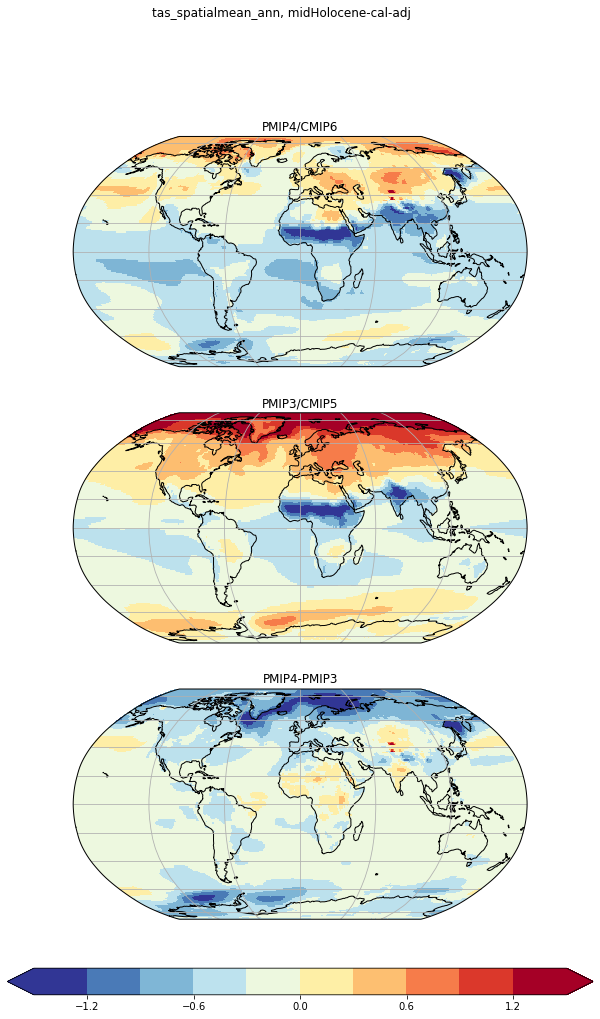

In [6]:
'''Annual mean temperature: ensemble average in deg_C, PMIP3 vs PMIP4.
Top two figures show the ensemble mean of changes (midHolocene-cal-adj minus piControl) in annual mean temperature in PMIP4 and PMIP3. 
The bottom one is the changes since PMIP3, it shows the difference between the top two figures.'''

tas_ave_plot(experiment_name,variable_name)


###  stddev

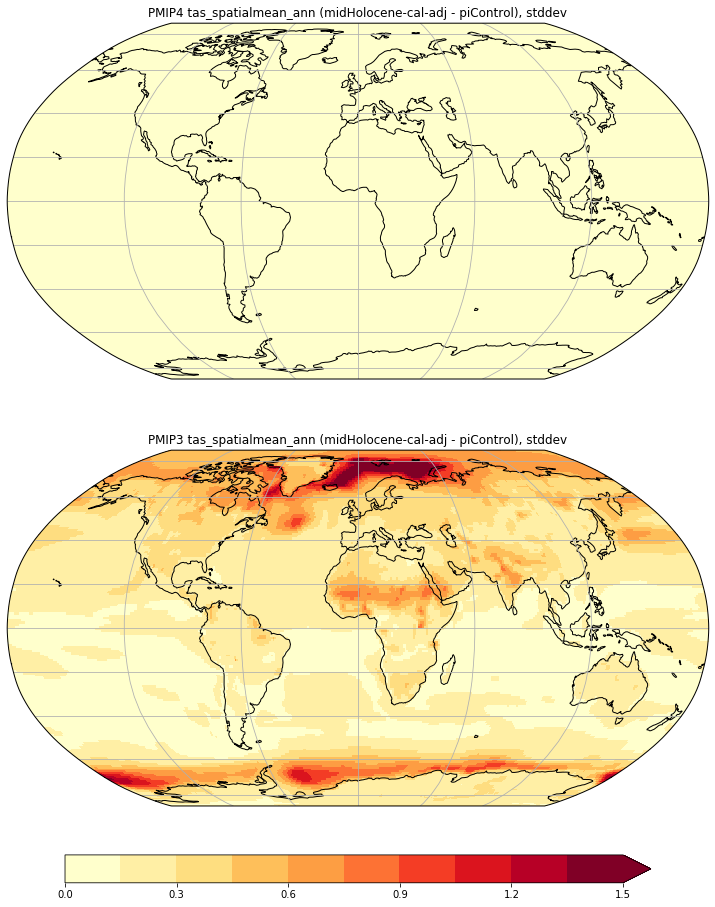

In [7]:
'''Annual mean temperature: ensemble uncertainty, PMIP3 vs PMIP4.
It shows the ensemble mean of standard deviation of changes (midHolocene-cal-adj minus piControl) in annual mean temperature in PMIP3. 
PMIP4 uncertainty is currently unavailable as we haven't got enough model data.'''

tas_std_plot(experiment_name,variable_name)

## midHolocene
This experiment simulate mid-Holocene without calendar adjustment. Figures' format and order are the same as midHolocene-cal-adj. 

In [4]:
experiment_name='midHolocene'
variable_name='tas_spatialmean_ann'



In [5]:
#PMIP3
ensemble_average_v3=ensemble_mean(pmip_v3)
ensemble_diff_v3=ensemble_mean_diffence(pmip_v3)
ensemble_stddev_v3=ensemble_stddev(pmip_v3)
#PMIP4
ensemble_average_v4=ensemble_mean(pmip_v4)
ensemble_diff_v4=ensemble_mean_diffence(pmip_v4)
ensemble_stddev_v4=ensemble_stddev(pmip_v4)
#PMIP4 - PMIP3
ensemble_diff_v=ensemble_diff_v4-ensemble_diff_v3



Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_60x128_180x360_peri.nc
Reuse existing file: bilinear_108x128_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_96x96_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x360_peri.nc
Reuse existing file: bilinear_160x320_180

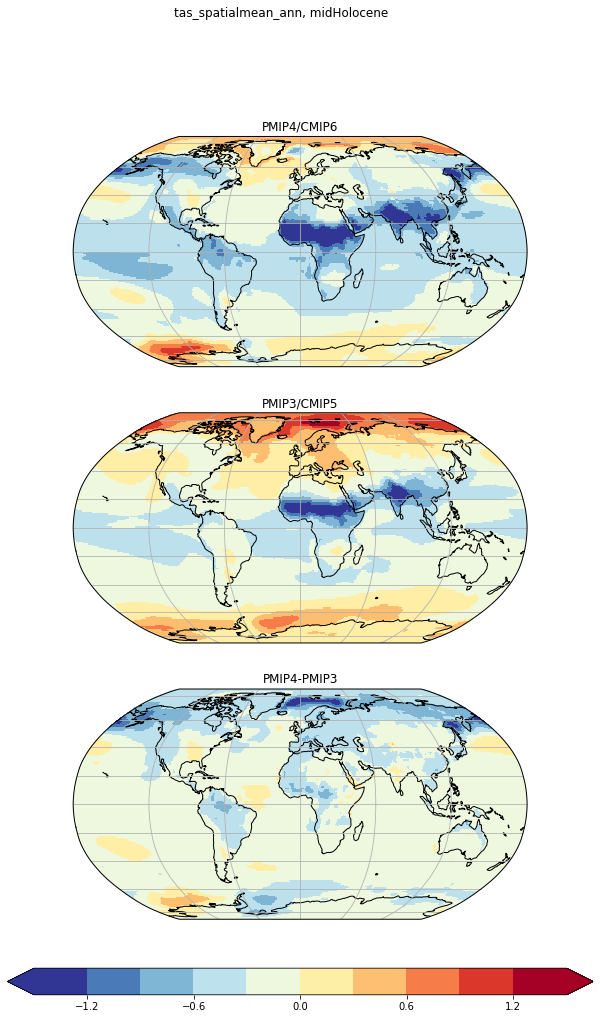

In [19]:
'''Annual mean temperature: ensemble average in deg_C, PMIP3 vs PMIP4.
Top two figures show the ensemble mean of changes (midHolocene minus piControl) in annual mean temperature in PMIP4 and PMIP3. 
The bottom one is the changes since PMIP3, it shows the difference between the top two figures.'''

tas_ave_plot(experiment_name,variable_name)

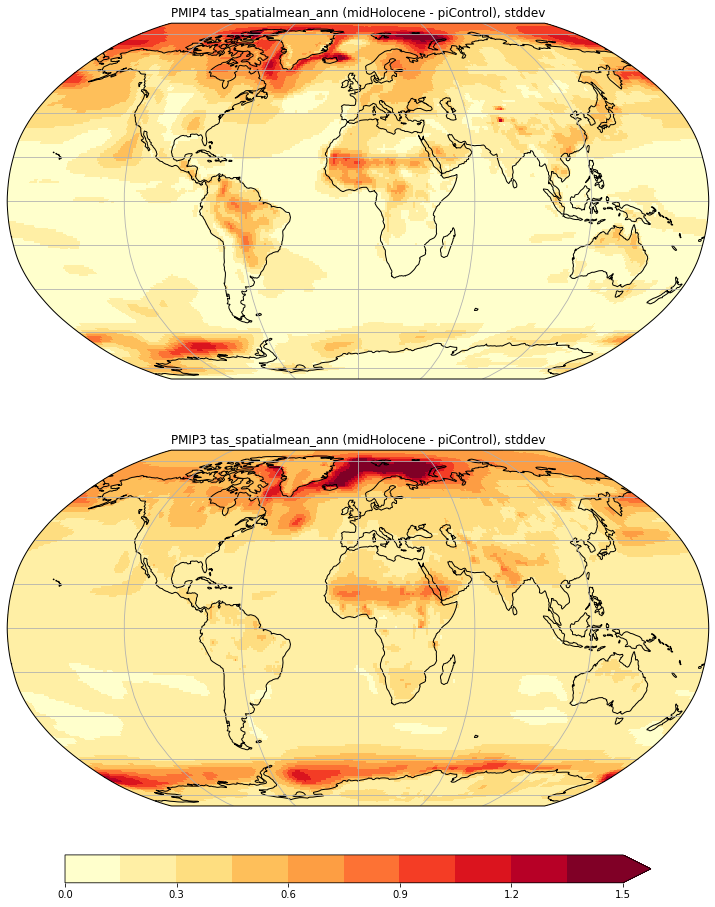

In [9]:
'''Annual mean temperature: ensemble uncertainty, PMIP3 vs PMIP4.
It shows the ensemble mean of standard deviation of changes (midHolocene minus piControl) in annual mean temperature in PMIP3. 
PMIP4 uncertainty is currently unavailable as we haven't got enough model data.'''

tas_std_plot(experiment_name,variable_name)

# 3. Calculations -- seasonal cycle of surface temp

## MTCO
DJF mean temperature

In [10]:
experiment_name='midHolocene-cal-adj'
variable_name='tas_spatialmean_djf'

#PMIP3
ensemble_average_v3=ensemble_mean(pmip_v3)
ensemble_diff_v3=ensemble_mean_diffence(pmip_v3)
ensemble_stddev_v3=ensemble_stddev(pmip_v3)
#PMIP4
ensemble_average_v4=ensemble_mean(pmip_v4)
ensemble_diff_v4=ensemble_mean_diffence(pmip_v4)
ensemble_stddev_v4=ensemble_stddev(pmip_v4)
#PMIP4 - PMIP3
ensemble_diff_v=ensemble_diff_v4-ensemble_diff_v3



Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_108x128_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_96x96_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_108x128_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_145x192

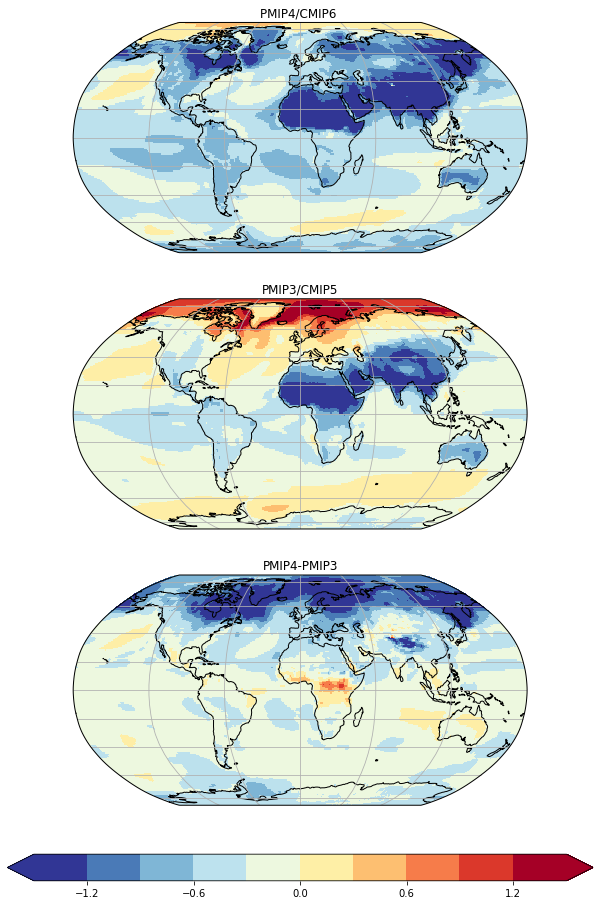

In [13]:
'''Changes in seasonal cycle of surface temp, MTCO: ensemble average in◦C, PMIP3 vs PMIP4.
Top two figures show theensemble mean of changes (midHolocene-cal-adj minus piControl) in DJF mean temperature in PMIP4 and PMIP3. 
The bottom one is thechanges since PMIP3, it shows the difference between the top two figures.)'''

tas_ave_plot(experiment_name,variable_name)

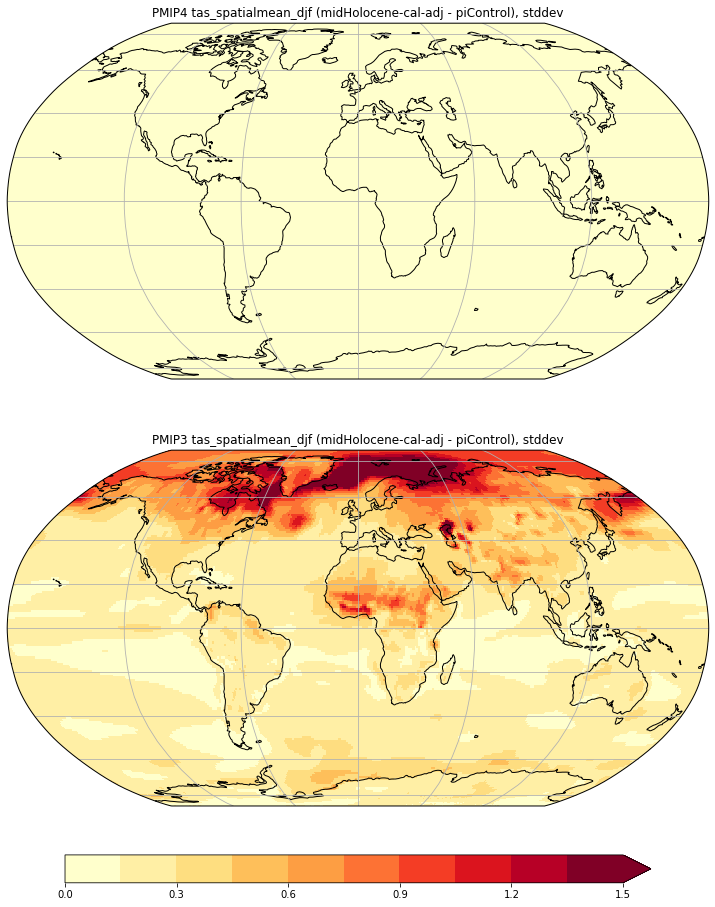

In [12]:
tas_std_plot(experiment_name,variable_name)

In [14]:
experiment_name='midHolocene'
variable_name='tas_spatialmean_djf'

#PMIP3
ensemble_average_v3=ensemble_mean(pmip_v3)
ensemble_diff_v3=ensemble_mean_diffence(pmip_v3)
ensemble_stddev_v3=ensemble_stddev(pmip_v3)
#PMIP4
ensemble_average_v4=ensemble_mean(pmip_v4)
ensemble_diff_v4=ensemble_mean_diffence(pmip_v4)
ensemble_stddev_v4=ensemble_stddev(pmip_v4)
#PMIP4 - PMIP3
ensemble_diff_v=ensemble_diff_v4-ensemble_diff_v3



Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_60x128_180x360_peri.nc
Reuse existing file: bilinear_108x128_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_96x96_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x360_peri.nc
Reuse existing file: bilinear_160x320_180

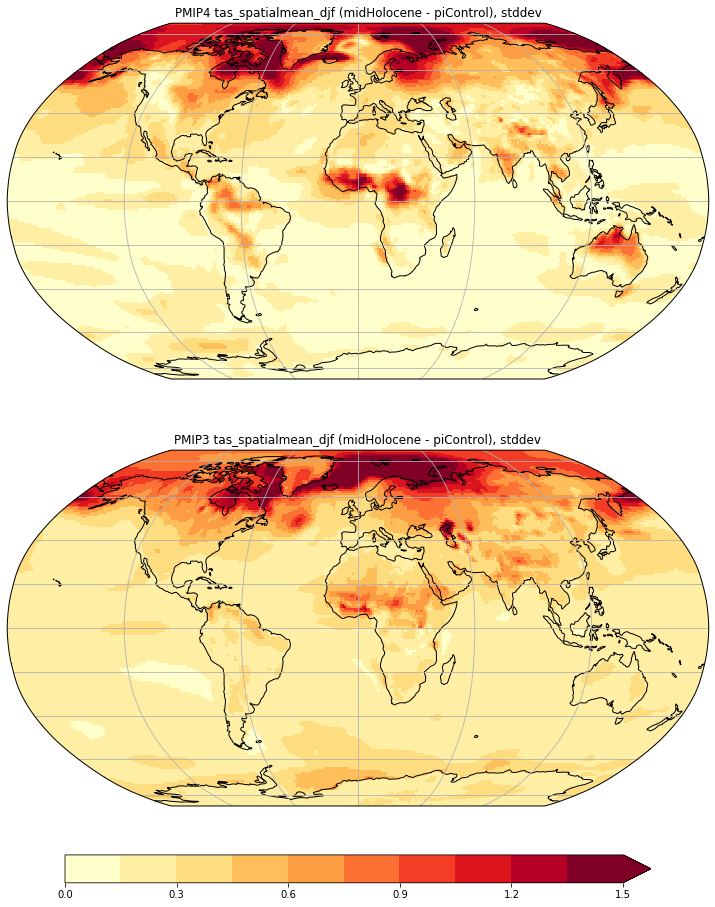

In [16]:
tas_std_plot(experiment_name,variable_name)

## MTWA
JJA mean temperature

In [17]:
experiment_name='midHolocene-cal-adj'
variable_name='tas_spatialmean_jja'

#PMIP3
ensemble_average_v3=ensemble_mean(pmip_v3)
ensemble_diff_v3=ensemble_mean_diffence(pmip_v3)
ensemble_stddev_v3=ensemble_stddev(pmip_v3)
#PMIP4
ensemble_average_v4=ensemble_mean(pmip_v4)
ensemble_diff_v4=ensemble_mean_diffence(pmip_v4)
ensemble_stddev_v4=ensemble_stddev(pmip_v4)
#PMIP4 - PMIP3
ensemble_diff_v=ensemble_diff_v4-ensemble_diff_v3



Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_108x128_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_96x96_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_108x128_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_145x192

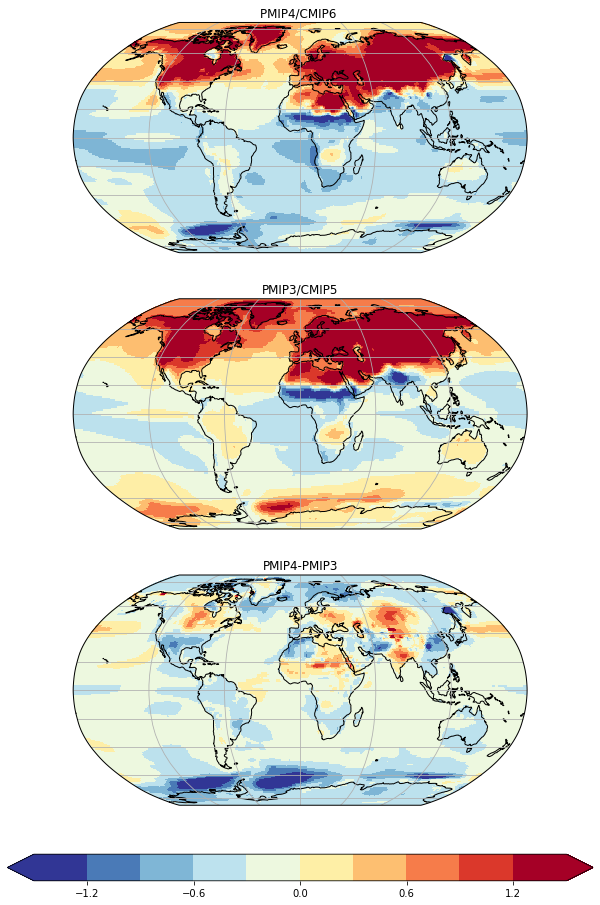

In [18]:
'''Same as MTCO, but for MTWA'''
tas_ave_plot(experiment_name,variable_name)

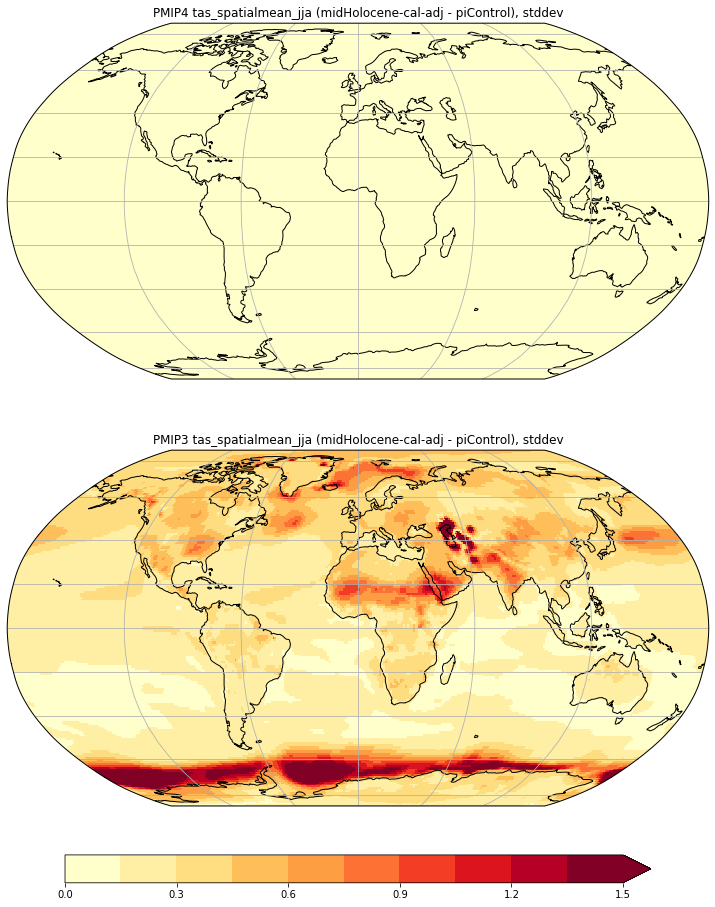

In [19]:
tas_std_plot(experiment_name,variable_name)

In [20]:
experiment_name='midHolocene'
variable_name='tas_spatialmean_jja'

#PMIP3
ensemble_average_v3=ensemble_mean(pmip_v3)
ensemble_diff_v3=ensemble_mean_diffence(pmip_v3)
ensemble_stddev_v3=ensemble_stddev(pmip_v3)
#PMIP4
ensemble_average_v4=ensemble_mean(pmip_v4)
ensemble_diff_v4=ensemble_mean_diffence(pmip_v4)
ensemble_stddev_v4=ensemble_stddev(pmip_v4)
#PMIP4 - PMIP3
ensemble_diff_v=ensemble_diff_v4-ensemble_diff_v3



Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_60x128_180x360_peri.nc
Reuse existing file: bilinear_108x128_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_96x96_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x360_peri.nc
Reuse existing file: bilinear_160x320_180

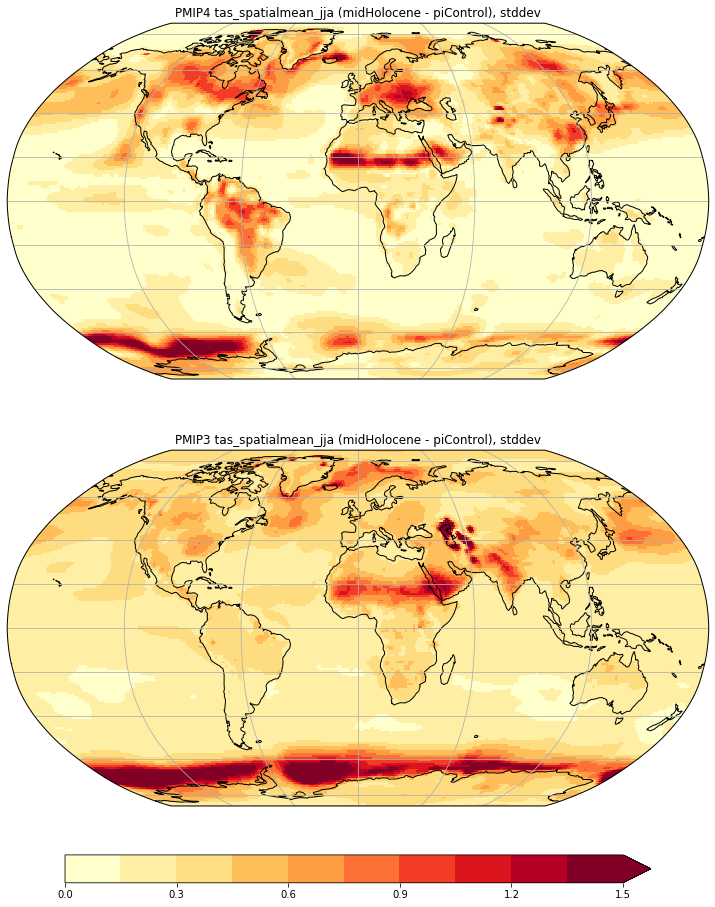

In [22]:
tas_std_plot(experiment_name,variable_name)

# 3. Calculations -- Hydrological cycle

JJA precipitation

In [23]:
experiment_name='midHolocene'
variable_name='pr_spatialmean_jja'

#PMIP3
ensemble_average_v3=ensemble_mean(pmip_v3)
ensemble_diff_v3=ensemble_mean_diffence(pmip_v3)
ensemble_stddev_v3=ensemble_stddev(pmip_v3)
#PMIP4
ensemble_average_v4=ensemble_mean(pmip_v4)
ensemble_diff_v4=ensemble_mean_diffence(pmip_v4)
ensemble_stddev_v4=ensemble_stddev(pmip_v4)
#PMIP4 - PMIP3
ensemble_diff_v=ensemble_diff_v4-ensemble_diff_v3




Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_60x128_180x360_peri.nc
Reuse existing file: bilinear_108x128_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_96x96_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x360_peri.nc
Reuse existing file: bilinear_160x320_180

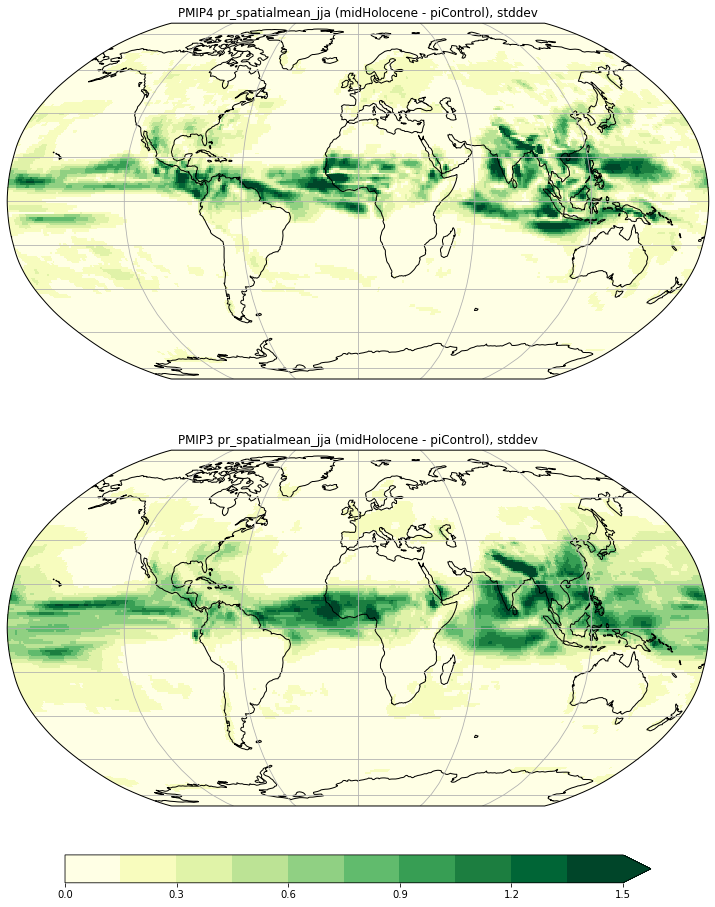

In [26]:
pr_std_plot(experiment_name,variable_name)

In [27]:
experiment_name='midHolocene-cal-adj'
variable_name='pr_spatialmean_jja'

#PMIP3
ensemble_average_v3=ensemble_mean(pmip_v3)
ensemble_diff_v3=ensemble_mean_diffence(pmip_v3)
ensemble_stddev_v3=ensemble_stddev(pmip_v3)
#PMIP4
ensemble_average_v4=ensemble_mean(pmip_v4)
ensemble_diff_v4=ensemble_mean_diffence(pmip_v4)
ensemble_stddev_v4=ensemble_stddev(pmip_v4)
#PMIP4 - PMIP3
ensemble_diff_v=ensemble_diff_v4-ensemble_diff_v3





Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_108x128_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_96x96_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_108x128_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_145x192

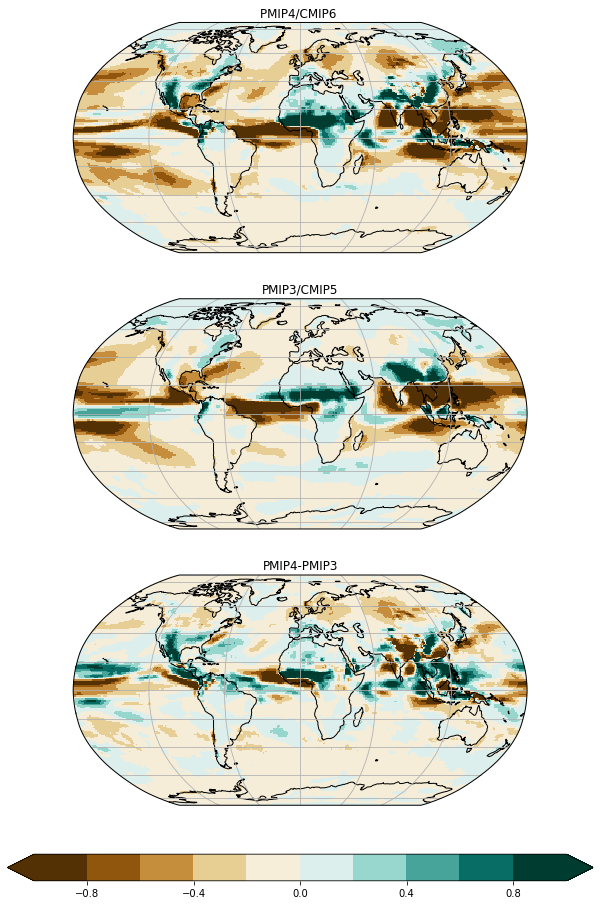

In [28]:
pr_ave_plot(experiment_name,variable_name)

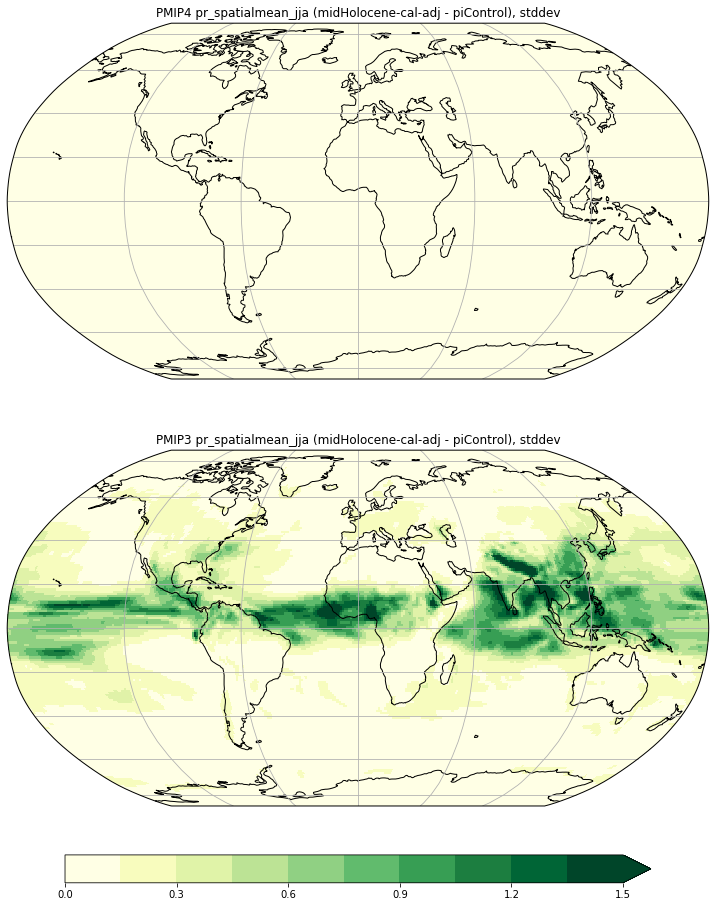

In [29]:
pr_std_plot(experiment_name,variable_name)

## JJA precipitaion

In [30]:
experiment_name='midHolocene-cal-adj'
variable_name='pr_spatialmean_djf'

#PMIP3
ensemble_average_v3=ensemble_mean(pmip_v3)
ensemble_diff_v3=ensemble_mean_diffence(pmip_v3)
ensemble_stddev_v3=ensemble_stddev(pmip_v3)
#PMIP4
ensemble_average_v4=ensemble_mean(pmip_v4)
ensemble_diff_v4=ensemble_mean_diffence(pmip_v4)
ensemble_stddev_v4=ensemble_stddev(pmip_v4)
#PMIP4 - PMIP3
ensemble_diff_v=ensemble_diff_v4-ensemble_diff_v3





Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_108x128_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_96x96_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_108x128_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_145x192

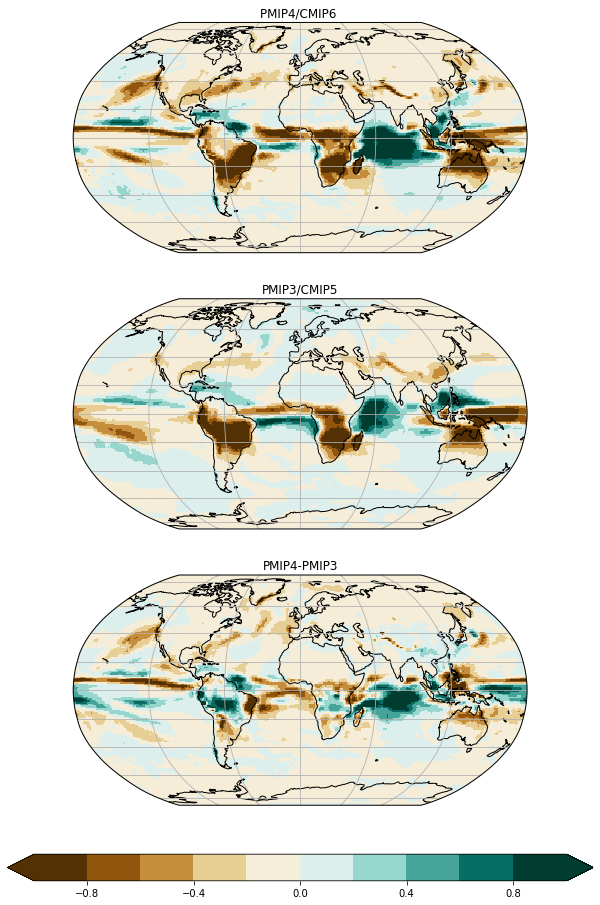

In [31]:
pr_ave_plot(experiment_name,variable_name)

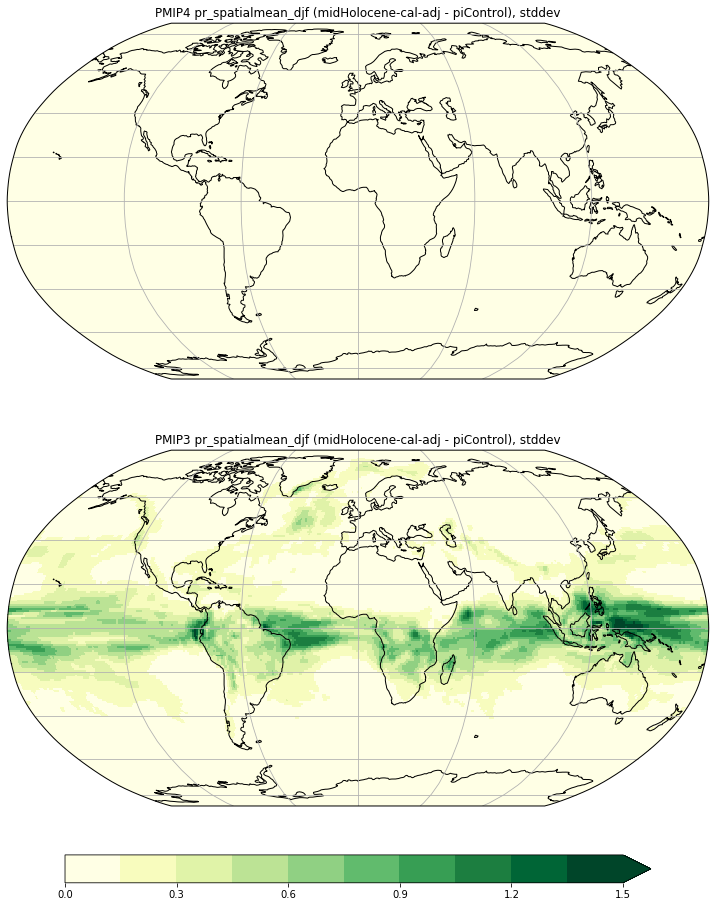

In [32]:
pr_std_plot(experiment_name,variable_name)

In [33]:
experiment_name='midHolocene'
variable_name='pr_spatialmean_djf'

#PMIP3
ensemble_average_v3=ensemble_mean(pmip_v3)
ensemble_diff_v3=ensemble_mean_diffence(pmip_v3)
ensemble_stddev_v3=ensemble_stddev(pmip_v3)
#PMIP4
ensemble_average_v4=ensemble_mean(pmip_v4)
ensemble_diff_v4=ensemble_mean_diffence(pmip_v4)
ensemble_stddev_v4=ensemble_stddev(pmip_v4)
#PMIP4 - PMIP3
ensemble_diff_v=ensemble_diff_v4-ensemble_diff_v3




Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_60x128_180x360_peri.nc
Reuse existing file: bilinear_108x128_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_96x96_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x360_peri.nc
Reuse existing file: bilinear_160x320_180

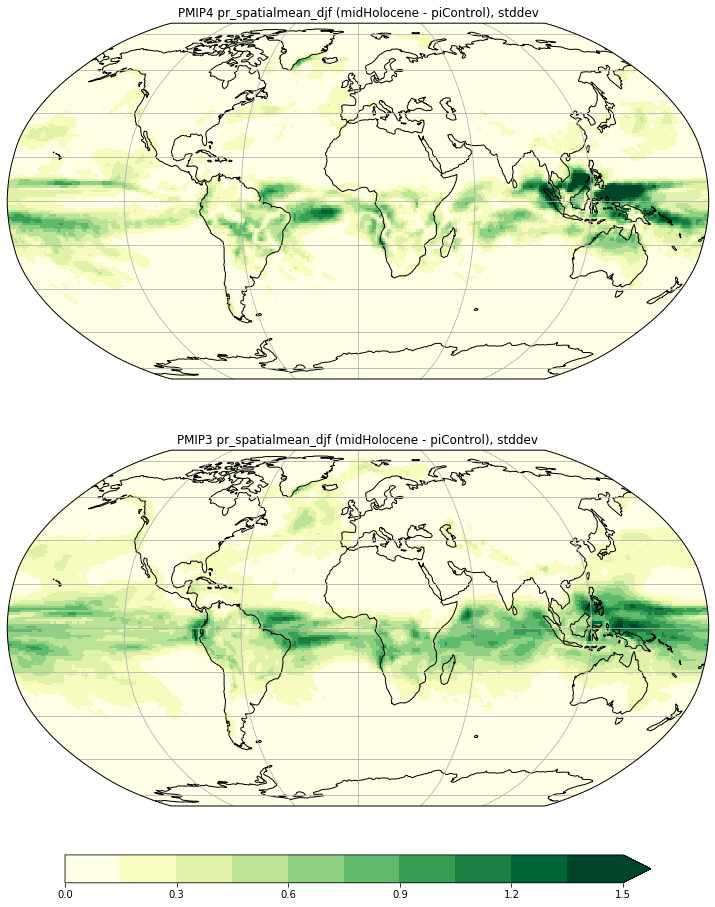

In [35]:
pr_std_plot(experiment_name,variable_name)